In [1]:
import torch
from torch import flip
from torch.nn import Module
from torch import nn
from torch.nn.functional import conv2d
from einops import rearrange
from torchvision.transforms.functional import resize
from torch.fft import fft2, ifft2
from sklearn.metrics import confusion_matrix, accuracy_score
import tqdm
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import functools
from datetime import datetime
import argparse
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from pprint import pprint
from  utils import *

CONFIG = type('', (), {})() # object for params

CONFIG.classes = 16
CONFIG.tiles_per_dim = int(math.sqrt(CONFIG.classes))

CONFIG.image_size = 28
CONFIG.train_class_instances = 8000
CONFIG.test_class_instances = 100
CONFIG.train_data_path = './assets/quickdraw16_train.npy'
CONFIG.test_data_path = './assets/quickdraw16_test.npy'

CONFIG.classifier_optimization_batch_size = 1280*2
CONFIG.classifier_optimization_epochs = 10000
CONFIG.learning_rate = 5e-5
CONFIG.pad_amount = 64
CONFIG.kernel_size = 33
CONFIG.tile_size = CONFIG.kernel_size * 2

CONFIG.classifier_model_path = './classifier.weights'

CONFIG.summary_every = 10
CONFIG.print_every = 10
CONFIG.save_every = 1000
CONFIG.verbose = True

print()
pprint(CONFIG.__dict__)
print()


{'classes': 16,
 'classifier_optimization_batch_size': 2560,
 'classifier_optimization_epochs': 10000,
 'image_size': 28,
 'kernel_size': 33,
 'learning_rate': 5e-05,
 'pad_amount': 64,
 'print_every': 10,
 'save_every': 1000,
 'summary_every': 10,
 'test_class_instances': 100,
 'test_data_path': './assets/quickdraw16_test.npy',
 'tile_size': 66,
 'tiles_per_dim': 4,
 'train_class_instances': 8000,
 'train_data_path': './assets/quickdraw16_train.npy',
 'verbose': True}



In [2]:
# change to your directory
train_data = torch.tensor(np.load(CONFIG.train_data_path), dtype=torch.float32)
test_data = torch.tensor(np.load(CONFIG.test_data_path), dtype=torch.float32)
train_data = rearrange(train_data, "b (h w) -> b 1 h w", h=CONFIG.image_size, w=CONFIG.image_size)
test_data = rearrange(test_data, "b (h w) -> b 1 h w", h=CONFIG.image_size, w=CONFIG.image_size)
train_data.shape, test_data.shape

(torch.Size([128000, 1, 28, 28]), torch.Size([1600, 1, 28, 28]))

In [3]:
train_labels = torch.eye(CONFIG.classes).repeat_interleave(repeats=CONFIG.train_class_instances, dim=0)
test_labels = torch.eye(CONFIG.classes).repeat_interleave(repeats=CONFIG.test_class_instances, dim=0)

# Examples of input data

<class 'torch.Tensor'>


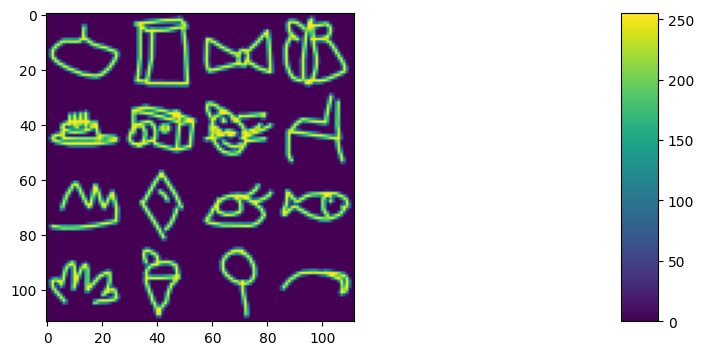

In [4]:
examples = []
for i in range(CONFIG.classes):
    examples.append(train_data[i*8000+2,0])
    
examples = torch.stack(examples)
examples = rearrange(examples, "(a b) h w -> (a h) (b w)", a=CONFIG.tiles_per_dim, b=CONFIG.tiles_per_dim)

imshow(examples);

# Baseline classifier

In [5]:
class CNNClassificator(Module):
    def __init__(self, input_size, kernel_size, filters):
        super().__init__()
        self.conv_weights = torch.nn.Parameter(
            torch.empty([filters, 1, kernel_size, kernel_size])
        )
        torch.nn.init.xavier_normal_(self.conv_weights)
        self.max_pool_layer = torch.nn.MaxPool2d(kernel_size=input_size)
        self.softmax = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = torch.nn.functional.conv2d(x, self.conv_weights.abs(), padding='same')
        x = self.max_pool_layer(x)
        x = x.squeeze()
        return x

In [6]:
classificator = CNNClassificator(
    input_size = train_data.shape[-2:], 
    kernel_size = CONFIG.kernel_size, 
    filters = CONFIG.classes
)
# classificator.load_state_dict(torch.load(CONFIG.classifier_model_path))
classificator.eval()

CNNClassificator(
  (max_pool_layer): MaxPool2d(kernel_size=torch.Size([28, 28]), stride=torch.Size([28, 28]), padding=0, dilation=1, ceil_mode=False)
  (softmax): Softmax(dim=1)
)

In [7]:
classificator = classificator.cuda()
inputs = train_data.cuda()
targets = train_labels.cuda()

In [8]:
optimizer = torch.optim.AdamW(params=classificator.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
loss_function = torch.nn.CrossEntropyLoss()

In [9]:
# training loop

epochs = CONFIG.classifier_optimization_epochs
batch_size = CONFIG.classifier_optimization_batch_size
ppp = tqdm.trange(epochs)

for epoch in ppp:
  batch_idxs = torch.randint(low=0, high=train_data.shape[0], size=[batch_size]) 
  batch_inputs = inputs[batch_idxs]
  batch_targets = targets[batch_idxs]
  # apply model
  predicted = classificator(batch_inputs)

  # correct model
  loss_value = loss_function(predicted, batch_targets)
  loss_value.backward()
  optimizer.step()

  if epoch % 100 == 0:
    acc = accuracy_score(to_class_labels(batch_targets), to_class_labels(predicted))
    ppp.set_postfix_str("loss: {:.3f}, acc: {:.2f}, lr: {:e}".format(loss_value, acc, scheduler.get_last_lr()[0]))
    
  if (scheduler.get_last_lr()[0] > 1e-6) and (epoch%100==0):
    scheduler.step()

100%|██████████| 10000/10000 [03:45<00:00, 44.30it/s, loss: 7.228, acc: 0.75, lr: 3.697296e-06]


In [10]:
inputs = test_data.cuda()
targets = test_labels.cuda()
predicted = classificator(inputs)
test_acc = accuracy_score(to_class_labels(targets), to_class_labels(predicted))
"Accuracy on test dataset: ", test_acc

('Accuracy on test dataset: ', 0.73875)

# Learned weights

torch.Size([1, 1, 264, 264])
<class 'torch.Tensor'>


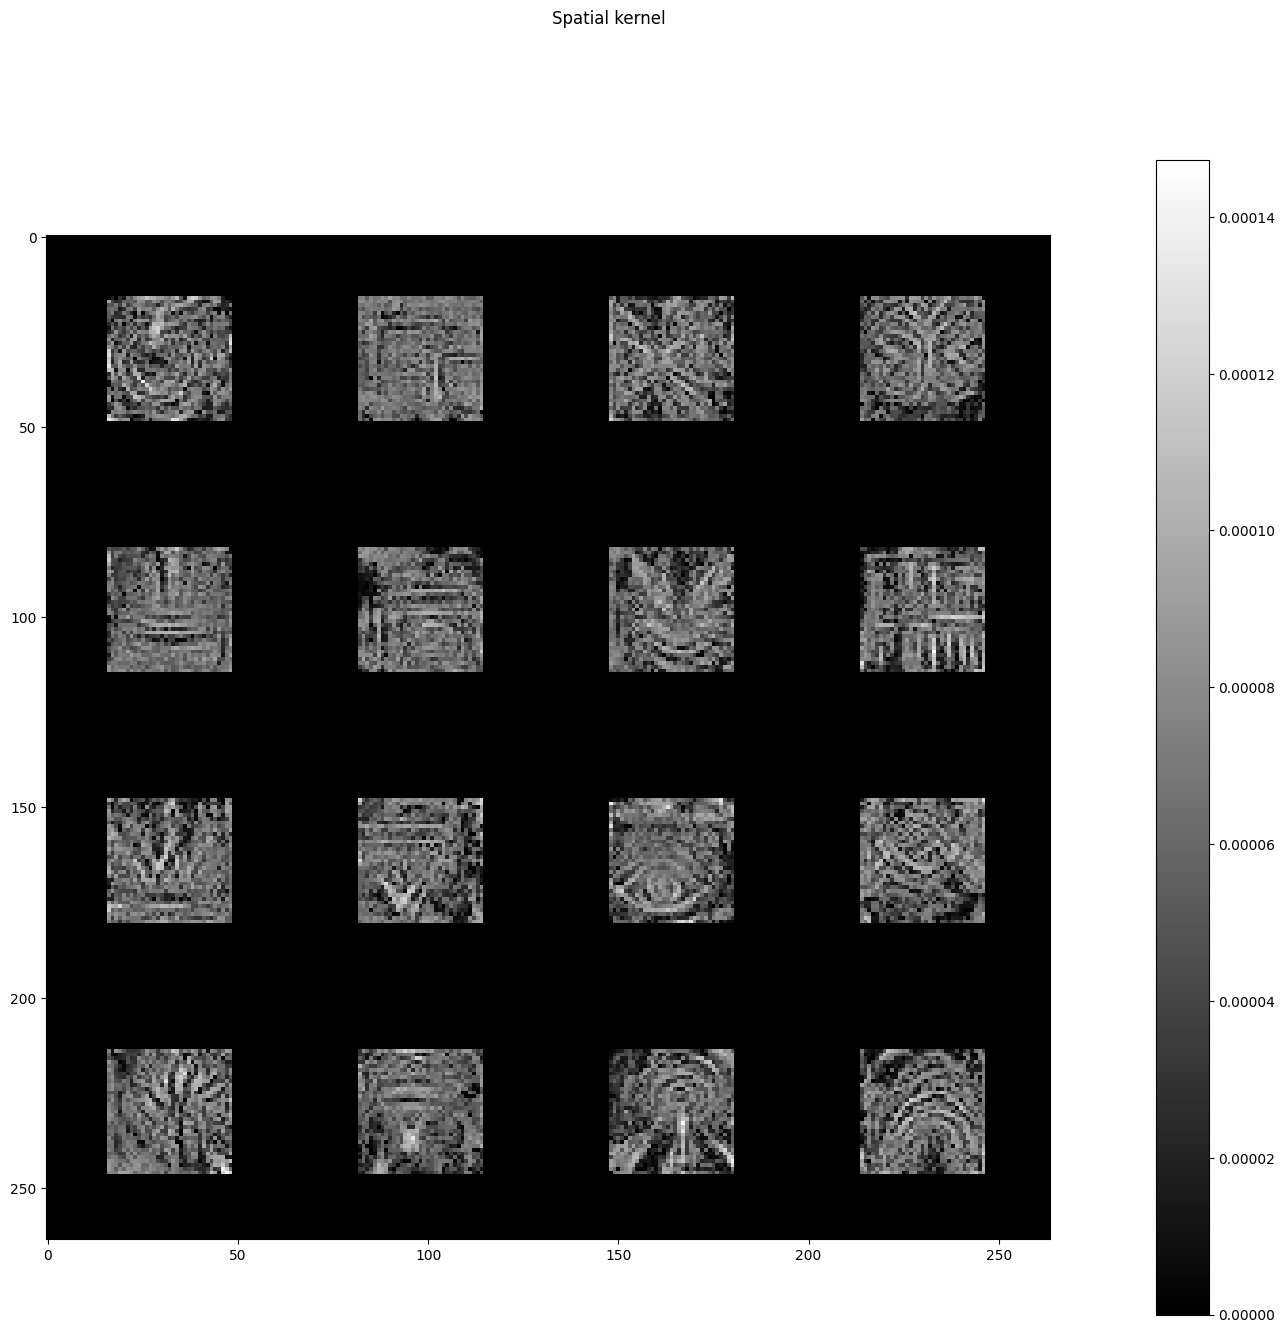

In [11]:
spatial_kernel = rearrange(
    pad_zeros(classificator.conv_weights.abs(), 
              size=(CONFIG.tile_size, CONFIG.tile_size)),
    "(a b) 1 h w -> 1 1 (a h) (b w)", a=int(math.sqrt(CONFIG.classes)), b=int(math.sqrt(CONFIG.classes))
)
spatial_kernel = spatial_kernel/spatial_kernel.sum(dim=[2,3], keepdim=True) # conservation of energy
spatial_kernel = spatial_kernel.detach()

print(spatial_kernel.shape)

imshow(spatial_kernel[0,0], cmap='gray', title="Spatial kernel", figsize=(15,15));

<class 'torch.Tensor'>


/tmp/ipykernel_10191/3562513726.py:4: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/Convolution.cpp:1031.)
  out = conv2d(spatial_kernel, image, padding='same')[0,0].cpu()
/tmp/ipykernel_10191/3562513726.py:4: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  out = conv2d(spatial_kernel, image, padding='same')[0,0].cpu()


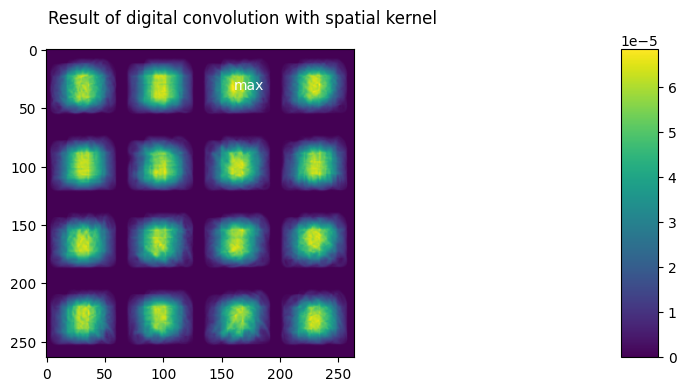

In [12]:
class_id = 2
# switch kernel and weights because image is smaller than one filter
image = inputs[class_id*CONFIG.test_class_instances:class_id*CONFIG.test_class_instances+1]
out = conv2d(spatial_kernel, image, padding='same')[0,0].cpu()
out = out.abs()
out = out/out.sum(dim=[0,1], keepdim=True)

f, ax = imshow(out.abs(), title="Result of digital convolution with spatial kernel")
y,x = (out==torch.max(out)).nonzero()[0]
ax[0].text(x,y, "max", color='white');

In [15]:
torch.save(classificator.state_dict(), CONFIG.classifier_model_path)